# Recurrent Neural Network (RNN) 

## Initialization

### Import Libraries

In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow / Keras Layers
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Label preprocessing
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import f1_score

2025-05-30 12:39:38.559690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 12:39:38.566778: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-30 12:39:38.587525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748583578.621641   35714 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748583578.631762   35714 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748583578.659726   35714 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### Import Data

In [2]:
df_train = pd.read_csv('../dataset/train.csv', sep=',')
df_val = pd.read_csv('../dataset/valid.csv', sep=',')
df_test = pd.read_csv('../dataset/test.csv', sep=',')

In [3]:
label_mapping = {
    'negative': 0,
    'neutral': 1,
    'positive': 2
}

for df in [df_train, df_val, df_test]:
    df['label_id'] = df['label'].map(label_mapping)

    if df['label_id'].isnull().any():
        print("Warning: Some labels were not mapped! Check unique labels and label_mapping.")
        print(df[df['label_id'].isnull()])

x_train = np.array(df_train['text'])
y_train = np.array(df_train['label_id'])

x_val = np.array(df_val['text'])
y_val = np.array(df_val['label_id'])

x_test = np.array(df_test['text'])
y_test = np.array(df_test['label_id'])

In [4]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape}, y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")

x_train shape: (500,), y_train shape: (500,)
x_val shape: (100,), y_val shape: (100,)
x_test shape: (400,), y_test shape: (400,)


### Preprocessing Result

(Actual preprocessing can be seen in tubes2_lstm.ipynb)
Since the number of unique tokens is not significantly large, we will use (2836+1) **2837 as the vocabulary size** (max_tokens) and take the 95th percentile value of **54 as the output_sequence_length**

In [5]:
MAX_TOKENS = 2837
OUTPUT_SEQUENCE_LENGTH = 54
EMBEDDING_DIM = 64
NUM_CLASSES = 3

MODEL_SAVE_DIR = '../bin/rnn_models'
PLOT_SAVE_DIR = '../bin/rnn_plots'

In [6]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
os.makedirs(PLOT_SAVE_DIR, exist_ok=True)

In [7]:
text_vectorization_layer = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int",
    output_sequence_length=OUTPUT_SEQUENCE_LENGTH
)

text_vectorization_layer.adapt(tf.data.Dataset.from_tensor_slices(x_train))

2025-05-30 12:40:00.883367: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-05-30 12:40:04.965958: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training and Prediction

### Boilerplate Functions

In [8]:
def calculate_macro_f1(y_true, y_pred_classes):
    return f1_score(y_true, y_pred_classes, average='macro')

def plot_training_history(history, title, filename):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)


    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_SAVE_DIR, filename))
    plt.show()
    plt.close()

In [9]:
def build_rnn_model(num_rnn_layers=1, rnn_units=64, rnn_direction='unidirectional', num_classes=NUM_CLASSES):
    model = models.Sequential()

    model.add(layers.Input(shape=(1,), dtype=tf.string))
    model.add(text_vectorization_layer)
    model.add(layers.Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM
    ))

    for i in range(num_rnn_layers):
        return_sequences = (i < num_rnn_layers - 1)

        if rnn_direction == 'unidirectional':
            model.add(layers.SimpleRNN(rnn_units,return_sequences=return_sequences))
        elif rnn_direction == 'bidirectional':
            model.add(layers.Bidirectional(layers.SimpleRNN(rnn_units,return_sequences=return_sequences)))
        else:
            raise ValueError("rnn_direction must be 'unidirectional' or 'bidirectional'")
        model.add(layers.Dropout(0.3))
    
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model



In [10]:
def train_and_evaluate_model(model_name, model_params, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    print(f"\n--- Training Model: {model_name} ---")
    model = build_rnn_model(**model_params)
    model.summary()

    # Define callbacks
    os.makedirs(MODEL_SAVE_DIR, exist_ok=True) # Ensure directory exists
    model_filepath = os.path.join(MODEL_SAVE_DIR, f'{model_name}_best.h5') # Use .h5 for full model

    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_weights_only=False,  # MUST BE False to create 'model_weights' group
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=0
    )
    early_stopping_callback = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=False, # CHANGED: Set to False
        verbose=0
    )

    history = model.fit(
        x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[checkpoint_callback, early_stopping_callback],
        verbose=1
    )

    plot_title = f"{model_name}"
    # You'll need to ensure plot_filename includes a valid path or that MODEL_SAVE_DIR is appropriate
    plot_filename_path = f"{model_name}_loss_accuracy.png"
    plot_training_history(history, plot_title, plot_filename_path)

    print(f"Best Keras model (full) saved to: {model_filepath}") # This file is ready for your Sequential class

    # These predictions will be based on the model state at the end of fit()
    y_val_pred_probs = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred_probs, axis=1)

    y_test_pred_probs = model.predict(x_test)
    y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)

    return history, y_val_pred_classes, y_test_pred_classes

In [11]:
def evaluate_macro_f1(y_true, y_pred, dataset_name="Validation"):
    """
    Calculates and prints the macro F1-score.
    """
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Macro F1-score on {dataset_name} set: {macro_f1:.4f}")
    return macro_f1

### Variation in Number of RNN Layers


--- Training Model: RNN_layers_1 ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,019 (742.26 KB)

 Trainable params: 190,019 (742.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3379 - loss: 1.1142

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.3538 - loss: 1.1107 - val_accuracy: 0.4100 - val_loss: 1.0824
Epoch 2/15
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6258 - loss: 0.9573

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6385 - loss: 0.9407 - val_accuracy: 0.4500 - val_loss: 1.0657
Epoch 3/15
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8855 - loss: 0.5311 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8901 - loss: 0.5163 - val_accuracy: 0.4700 - val_loss: 1.0620
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9764 - loss: 0.2182 - val_accuracy: 0.4900 - val_loss: 1.1419
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9955 - loss: 0.0931 - val_accuracy: 0.5000 - val_loss: 1.2474
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0404 - val_accuracy: 0.5000 - val_loss: 1.3545
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0218 - val_accuracy: 0.5200 - val_loss: 1.3763
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0133 - val_accuracy: 0.5200 - val_loss: 1.4434


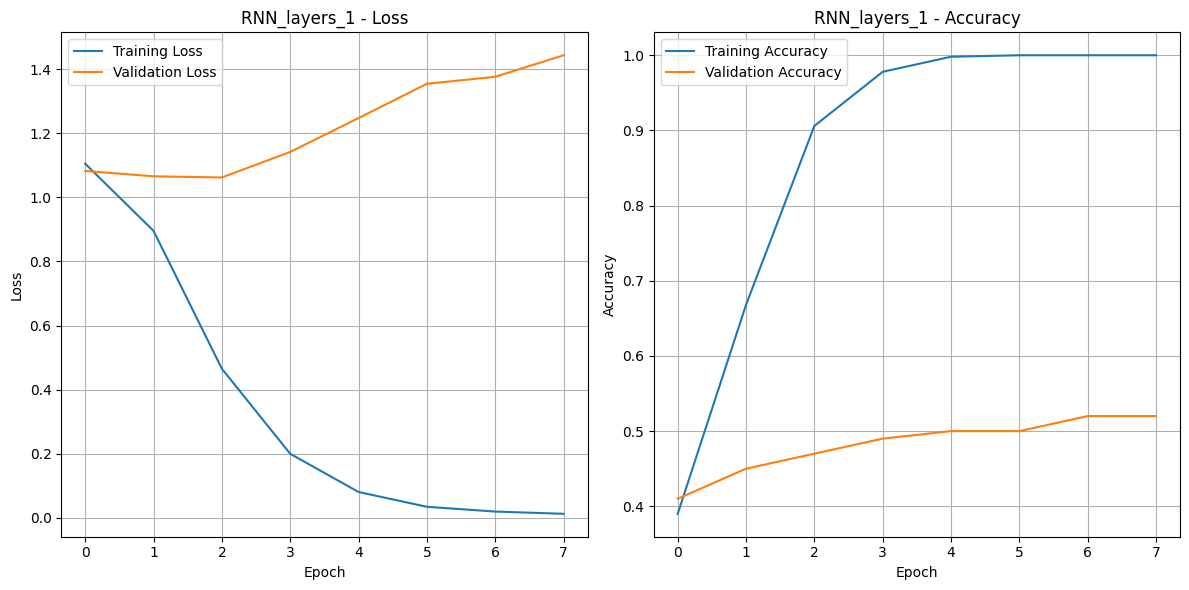

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_1_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Macro F1-score on Validation set: 0.4912
Macro F1-score on Test set: 0.4032

--- Training Model: RNN_layers_2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3488 - loss: 1.1660

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.3509 - loss: 1.1622 - val_accuracy: 0.4800 - val_loss: 0.9847
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5905 - loss: 0.8618 - val_accuracy: 0.4600 - val_loss: 1.0994
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8459 - loss: 0.5290 - val_accuracy: 0.5400 - val_loss: 1.1216
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9833 - loss: 0.1690 - val_accuracy: 0.4900 - val_loss: 1.4335
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9964 - loss: 0.0480 - val_accuracy: 0.4300 - val_loss: 1.4940
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0181 - val_accuracy: 0.4600 - val_loss: 1.6768


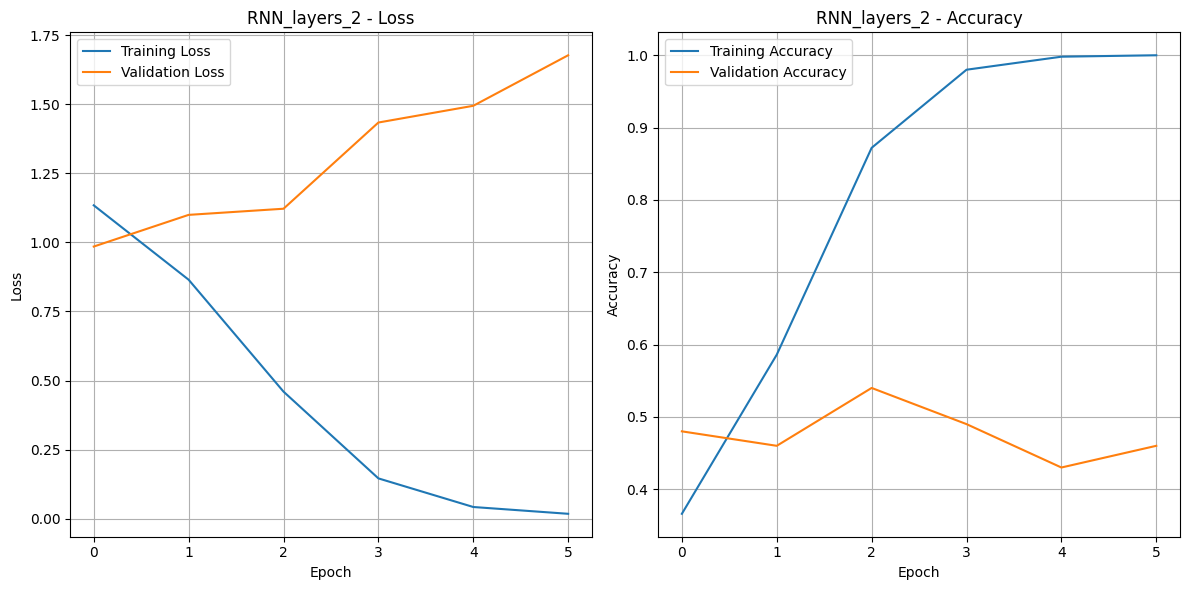

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_2_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Macro F1-score on Validation set: 0.4451
Macro F1-score on Test set: 0.4602

--- Training Model: RNN_layers_3 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,531 (806.76 KB)

 Trainable params: 206,531 (806.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3887 - loss: 1.2202

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.3863 - loss: 1.2221 - val_accuracy: 0.3700 - val_loss: 1.0871
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4691 - loss: 1.0486 - val_accuracy: 0.3500 - val_loss: 1.3726
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6714 - loss: 0.6984 - val_accuracy: 0.3800 - val_loss: 1.5611
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8980 - loss: 0.3328 - val_accuracy: 0.3900 - val_loss: 1.7092
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9815 - loss: 0.1158 - val_accuracy: 0.3600 - val_loss: 2.3579
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0436 - val_accuracy: 0.3700 - val_loss: 2.1932


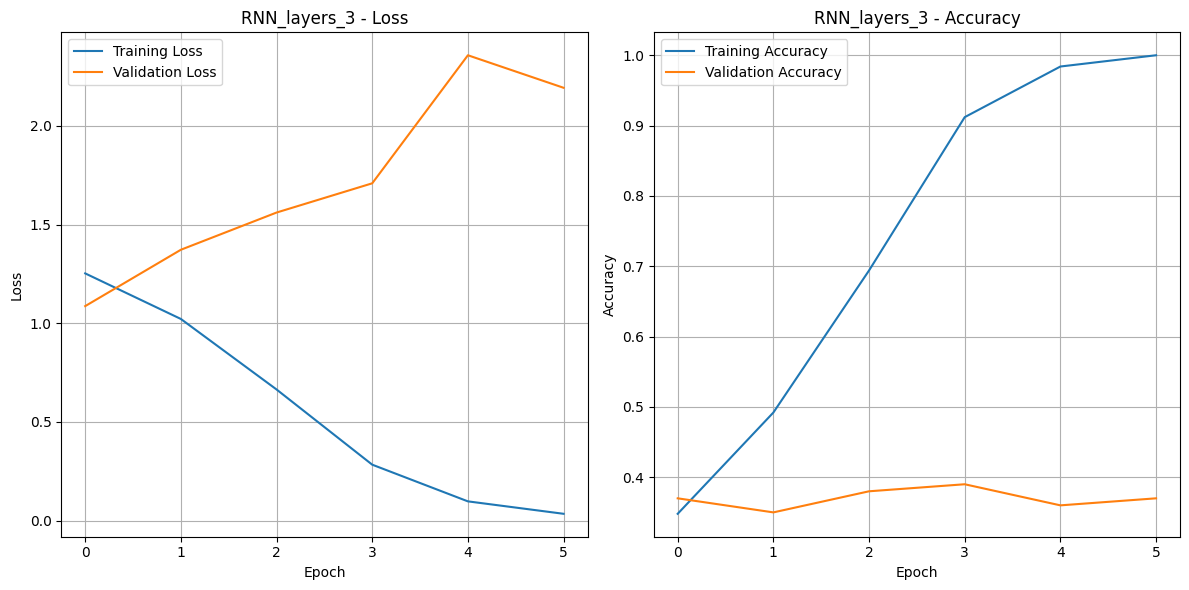

Best Keras model (full) saved to: ../bin/rnn_models/RNN_layers_3_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1-score on Validation set: 0.3706
Macro F1-score on Test set: 0.4901

--- Summary: Pengaruh jumlah layer RNN ---
RNN_layers_1: Validation Macro F1 = 0.4912, Test Macro F1 = 0.4032
RNN_layers_2: Validation Macro F1 = 0.4451, Test Macro F1 = 0.4602
RNN_layers_3: Validation Macro F1 = 0.3706, Test Macro F1 = 0.4901


In [12]:
rnn_layer_variations = [1,2,3]

results_layer_count = {}

for num_layers in rnn_layer_variations:
    model_params = {
        'num_rnn_layers' : num_layers,
        'rnn_units' : 64,
        'rnn_direction' : 'unidirectional'
    }
    model_name = f"RNN_layers_{num_layers}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_layer_count[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jumlah layer RNN ---")
for name, res in results_layer_count.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")


### Variation in Number of RNN Cells


--- Training Model: RNN_Units_32 ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 54, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 54, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,851 (729.89 KB)

 Trainable params: 186,851 (729.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3510 - loss: 1.2462

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - accuracy: 0.3530 - loss: 1.2357 - val_accuracy: 0.3500 - val_loss: 1.0802
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3794 - loss: 1.0863 - val_accuracy: 0.4200 - val_loss: 1.0892
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5300 - loss: 0.9227 - val_accuracy: 0.4400 - val_loss: 1.1262
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8631 - loss: 0.4912 - val_accuracy: 0.4900 - val_loss: 1.2476
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9564 - loss: 0.2450 - val_accuracy: 0.4900 - val_loss: 1.3714
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9871 - loss: 0.1326 - val_accuracy: 0.4600 - val_loss: 1.5571


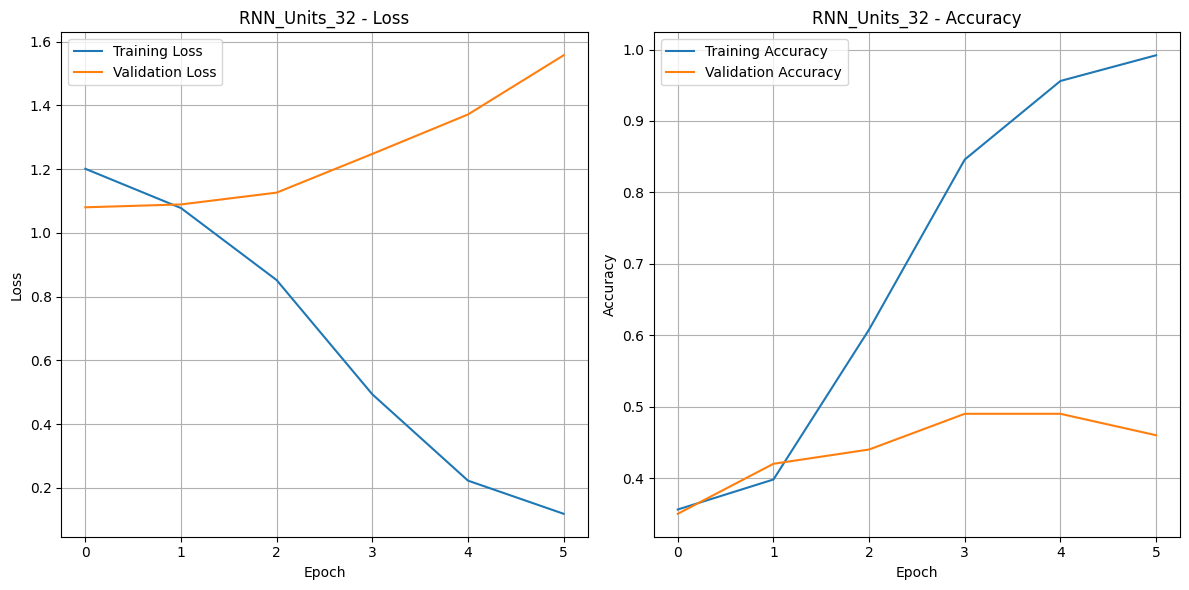

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_32_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Macro F1-score on Validation set: 0.4442
Macro F1-score on Test set: 0.4128

--- Training Model: RNN_Units_64 ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3698 - loss: 1.1374

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3719 - loss: 1.1382 - val_accuracy: 0.5100 - val_loss: 1.0052
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4838 - loss: 1.0266 - val_accuracy: 0.4900 - val_loss: 1.1551
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6749 - loss: 0.7382 - val_accuracy: 0.4200 - val_loss: 1.1598
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9076 - loss: 0.3216 - val_accuracy: 0.3700 - val_loss: 1.6228
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9892 - loss: 0.0725 - val_accuracy: 0.4100 - val_loss: 1.7419
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9992 - loss: 0.0280 - val_accuracy: 0.4100 - val_loss: 1.7228


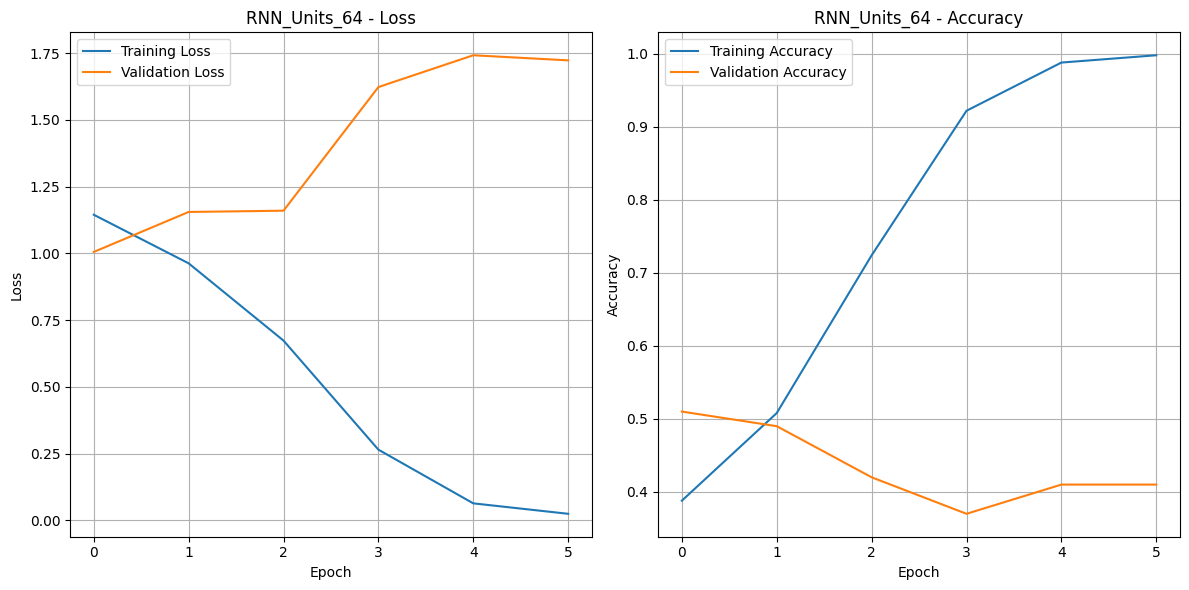

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_64_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.4032
Macro F1-score on Test set: 0.4536

--- Training Model: RNN_Units_128 ---


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_10 (SimpleRNN)       │ (None, 54, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,555 (935.76 KB)

 Trainable params: 239,555 (935.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4378 - loss: 1.0882

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.4365 - loss: 1.0907 - val_accuracy: 0.3700 - val_loss: 1.1873
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4342 - loss: 1.1310

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4379 - loss: 1.1253 - val_accuracy: 0.4700 - val_loss: 1.0838
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5944 - loss: 0.8022

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5984 - loss: 0.7968 - val_accuracy: 0.5800 - val_loss: 0.9526
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8512 - loss: 0.3697 - val_accuracy: 0.4900 - val_loss: 1.1634
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9580 - loss: 0.1573 - val_accuracy: 0.5400 - val_loss: 1.2550
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9869 - loss: 0.0545 - val_accuracy: 0.5000 - val_loss: 1.5095
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.5600 - val_loss: 1.2809
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 1.0000 - loss: 0.0083 - val_accuracy: 0.5200 - val_loss: 1.5531


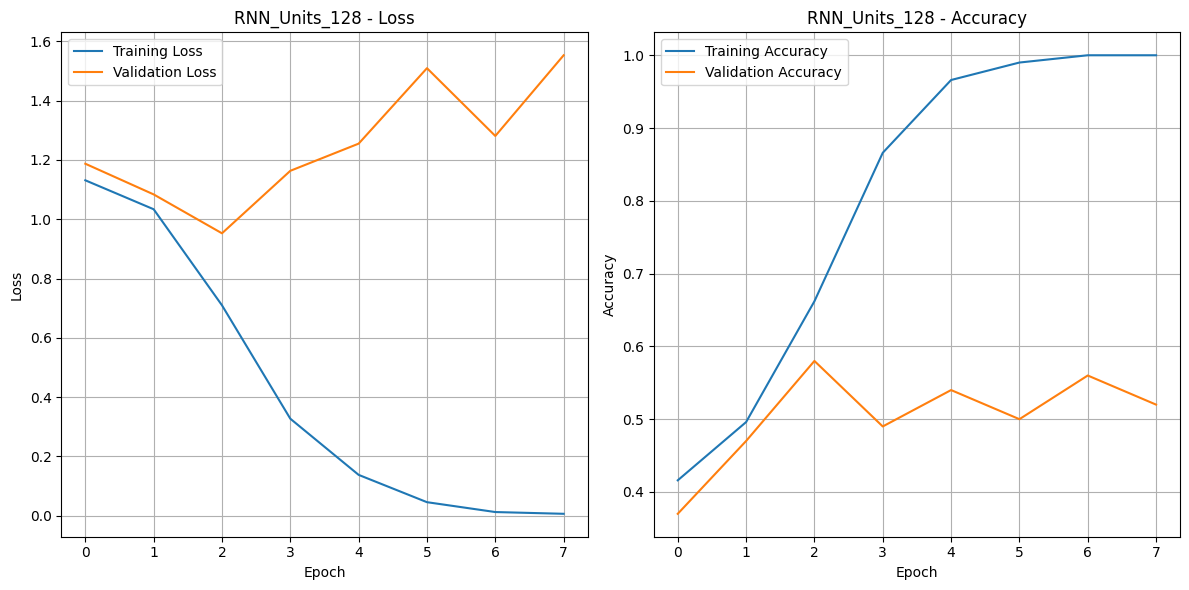

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Units_128_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Macro F1-score on Validation set: 0.5143
Macro F1-score on Test set: 0.4969

--- Summary: Pengaruh banyak cell RNN per layer ---
RNN_Units_32: Validation Macro F1 = 0.4442, Test Macro F1 = 0.4128
RNN_Units_64: Validation Macro F1 = 0.4032, Test Macro F1 = 0.4536
RNN_Units_128: Validation Macro F1 = 0.5143, Test Macro F1 = 0.4969


In [13]:
rnn_units_variations = [32, 64, 128]

results_units = {}

for units in rnn_units_variations:
    model_params = {
        'num_rnn_layers': 2,
        'rnn_units': units,
        'rnn_direction': 'unidirectional'
    }
    model_name = f"RNN_Units_{units}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_units[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh banyak cell RNN per layer ---")
for name, res in results_units.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Variation in RNN Layer Direction


--- Training Model: RNN_Direction_unidirectional ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,275 (774.51 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
14/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3787 - loss: 1.1505

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3789 - loss: 1.1476 - val_accuracy: 0.5500 - val_loss: 0.9870
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5144 - loss: 0.9600 - val_accuracy: 0.4800 - val_loss: 1.0197
Epoch 3/15
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6698 - loss: 0.7097

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6934 - loss: 0.6812 - val_accuracy: 0.5700 - val_loss: 0.9360
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9516 - loss: 0.2477 - val_accuracy: 0.6400 - val_loss: 0.9803
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9967 - loss: 0.0560 - val_accuracy: 0.5600 - val_loss: 1.0652
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.5100 - val_loss: 1.2495
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0115 - val_accuracy: 0.5400 - val_loss: 1.1704
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0072 - val_accuracy: 0.5500 - val_loss: 1.2297


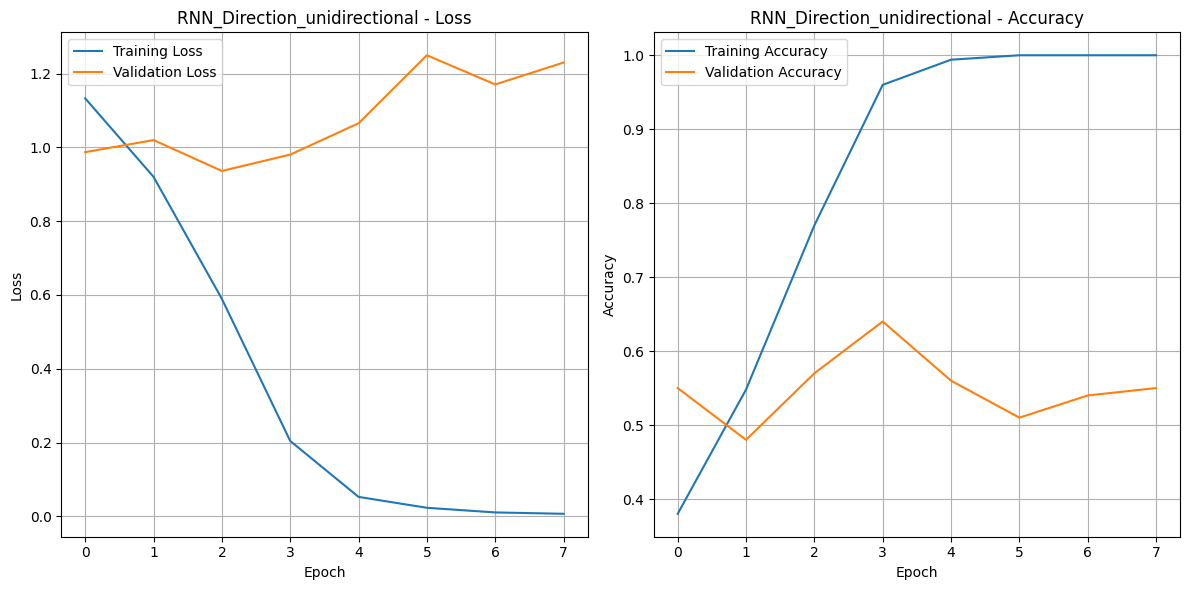

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Direction_unidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Macro F1-score on Validation set: 0.5211
Macro F1-score on Test set: 0.4903

--- Training Model: RNN_Direction_bidirectional ---


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 54, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,171 (871.76 KB)

 Trainable params: 223,171 (871.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3165 - loss: 1.1849

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3172 - loss: 1.1836 - val_accuracy: 0.4300 - val_loss: 1.0822
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5847 - loss: 0.8964

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5872 - loss: 0.8929 - val_accuracy: 0.4100 - val_loss: 1.0246
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8541 - loss: 0.5117 - val_accuracy: 0.4400 - val_loss: 1.2129
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9143 - loss: 0.2321 - val_accuracy: 0.4800 - val_loss: 1.1712
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0451 - val_accuracy: 0.4300 - val_loss: 1.3677
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0187 - val_accuracy: 0.4300 - val_loss: 1.4080
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.4600 - val_loss: 1.4298


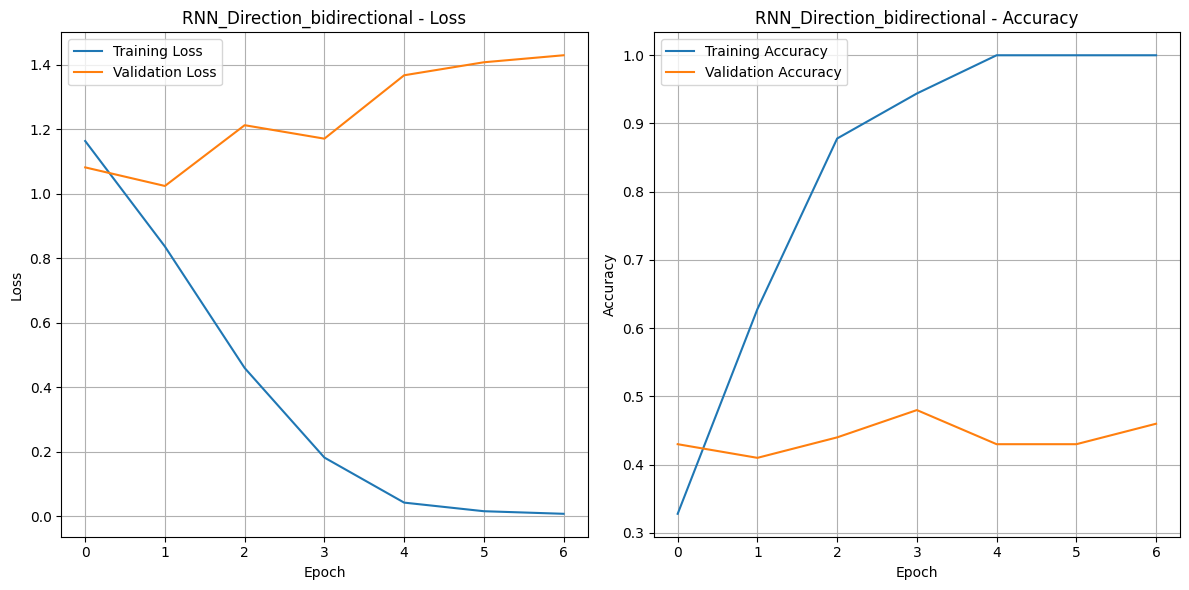

Best Keras model (full) saved to: ../bin/rnn_models/RNN_Direction_bidirectional_best.h5
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Macro F1-score on Validation set: 0.4513
Macro F1-score on Test set: 0.4309

--- Summary: Pengaruh jenis layer rnn berdasarkan arah ---
RNN_Direction_unidirectional: Validation Macro F1 = 0.5211, Test Macro F1 = 0.4903
RNN_Direction_bidirectional: Validation Macro F1 = 0.4513, Test Macro F1 = 0.4309


In [16]:
rnn_direction_variations = ['unidirectional', 'bidirectional']

results_direction = {}

for direction in rnn_direction_variations:
    model_params = {
        'num_rnn_layers': 2,
        'rnn_units': 64,
        'rnn_direction': direction
    }
    model_name = f"RNN_Direction_{direction}"

    history, y_val_pred, y_test_pred = train_and_evaluate_model(
        model_name,
        model_params,
        x_train, y_train, x_val, y_val,
        epochs=15
    )

    val_macro_f1 = evaluate_macro_f1(y_val, y_val_pred, "Validation")
    test_macro_f1 = evaluate_macro_f1(y_test, y_test_pred, "Test")

    results_direction[model_name] = {
        'val_macro_f1': val_macro_f1,
        'test_macro_f1': test_macro_f1,
        'history': history
    }

print("\n--- Summary: Pengaruh jenis layer rnn berdasarkan arah ---")
for name, res in results_direction.items():
    print(f"{name}: Validation Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")

### Overall Analysis and Conclusions

In [18]:
# Helper function to print conclusions clearly
def print_conclusion(experiment_name, results_dict):
    print(f"\n--- {experiment_name} ---")
    best_val_f1 = -1
    best_model_name = ""
    for name, res in results_dict.items():
        print(f"{name}: Val Macro F1 = {res['val_macro_f1']:.4f}, Test Macro F1 = {res['test_macro_f1']:.4f}")
        if res['val_macro_f1'] > best_val_f1:
            best_val_f1 = res['val_macro_f1']
            best_model_name = name
    print(f"Best performing model in this experiment (based on Validation F1): {best_model_name} (F1: {best_val_f1:.4f})")

print_conclusion("Pengaruh jumlah layer RNN", results_layer_count)
print_conclusion("Pengaruh banyak cell RNN per layer", results_units)
print_conclusion("Pengaruh jenis layer RNN berdasarkan arah", results_direction)


--- Pengaruh jumlah layer RNN ---
RNN_layers_1: Val Macro F1 = 0.4912, Test Macro F1 = 0.4032
RNN_layers_2: Val Macro F1 = 0.4451, Test Macro F1 = 0.4602
RNN_layers_3: Val Macro F1 = 0.3706, Test Macro F1 = 0.4901
Best performing model in this experiment (based on Validation F1): RNN_layers_1 (F1: 0.4912)

--- Pengaruh banyak cell RNN per layer ---
RNN_Units_32: Val Macro F1 = 0.4442, Test Macro F1 = 0.4128
RNN_Units_64: Val Macro F1 = 0.4032, Test Macro F1 = 0.4536
RNN_Units_128: Val Macro F1 = 0.5143, Test Macro F1 = 0.4969
Best performing model in this experiment (based on Validation F1): RNN_Units_128 (F1: 0.5143)

--- Pengaruh jenis layer RNN berdasarkan arah ---
RNN_Direction_unidirectional: Val Macro F1 = 0.5211, Test Macro F1 = 0.4903
RNN_Direction_bidirectional: Val Macro F1 = 0.4513, Test Macro F1 = 0.4309
Best performing model in this experiment (based on Validation F1): RNN_Direction_unidirectional (F1: 0.5211)


## Forward Pass Comparison

In [39]:
unidirection_to_load = f"{MODEL_SAVE_DIR}/RNN_Direction_unidirectional_best.h5"
bidirection_to_load = f"{MODEL_SAVE_DIR}/RNN_Direction_bidirectional_best.h5"

### Unidirectional Model

In [40]:
from sequential import Sequential
from layers.text_vectorization import TextVectorizationWrapper
from layers.embedding import Embedding
from layers.dense import Dense
from layers.dropout import Dropout
from layers.simple_rnn import SimpleRNN
from layers.bidirectional import Bidirectional

custom_unidirectional_rnn = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM
    ),
    SimpleRNN(units=64, return_sequences=True),
    Dropout(),
    SimpleRNN(units=64,return_sequences=False),
    Dropout(),
    Dense(3,activation="softmax")
])

In [41]:
custom_unidirectional_rnn.load_weights(unidirection_to_load)

HDF5 layer keys: ['dense_8', 'dropout_16', 'dropout_17', 'embedding_8', 'simple_rnn_16', 'simple_rnn_17', 'text_vectorization', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_8)
Loading 3 weight array(s) into layer 2 (type: SimpleRNN, key: simple_rnn_16)
Weight successfuly loaded
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_16)
Dropout has no trainable weights — skipping
Loading 3 weight array(s) into layer 4 (type: SimpleRNN, key: simple_rnn_17)
Weight successfuly loaded
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_17)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_8)


In [42]:
keras_model_unidirectional = tf.keras.models.load_model(unidirection_to_load)
keras_model_unidirectional.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_8 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_16 (SimpleRNN)       │ (None, 54, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 54, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,277 (774.52 KB)

 Trainable params: 198,275 (774.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [43]:
text_vectorization_layer_loaded = None
for layer in keras_model_unidirectional.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [44]:
y_test_pred_probs = keras_model_unidirectional.predict(x_test)
print(y_test_pred_probs[:5])
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred_classes[:5])

evaluate_macro_f1(y_test, y_test_pred_classes, "Unidirectional Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
[[0.6624218  0.02798308 0.30959505]
 [0.24755834 0.52590024 0.22654139]
 [0.3214818  0.6022077  0.07631041]
 [0.758148   0.06142315 0.18042877]
 [0.357457   0.34098232 0.3015607 ]]
[0 1 1 0 0]
Macro F1-score on Unidirectional Keras Model Test set: 0.5272


0.5272490448332561

In [45]:
# 1. Perform prediction with your custom model
print("\n--- Predicting with Custom Sequential Model ---")
custom_model_pred_probs = custom_unidirectional_rnn.predict(x_test)
print(custom_model_pred_probs[:5])
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)
print(custom_model_pred_classes[:50])

# 2. Calculate F1 score for your custom model
# You'll need an evaluation function, similar to what you used for the Keras model
# (Assuming you have an 'evaluate_macro_f1' function)
evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Model Test")


--- Predicting with Custom Sequential Model ---
[[0.66242153 0.02798307 0.3095954 ]
 [0.247558   0.52590066 0.22654134]
 [0.32148102 0.60220856 0.07631042]
 [0.75814798 0.06142309 0.18042894]
 [0.35745684 0.34098166 0.3015615 ]]
[0 1 1 0 0 0 1 1 2 0 1 2 1 0 1 0 1 2 1 2 0 2 2 0 1 0 2 2 0 2 1 1 2 0 2 1 1
 0 2 2 2 2 1 0 0 0 1 1 1 1]
Macro F1-score on Custom Model Test set: 0.5272


0.5272490448332561

### Bidirectional Model

In [ ]:
custom_bidirectional_rnn = Sequential([
    TextVectorizationWrapper(TextVectorizer=text_vectorization_layer),
    Embedding(
        input_dim=MAX_TOKENS,
        output_dim=EMBEDDING_DIM
    ),
    Bidirectional(SimpleRNN(units=64, return_sequences=True)),
    Dropout(),
    Bidirectional(SimpleRNN(units=64,return_sequences=False)),
    Dropout(),
    Dense(3,activation="softmax")
])

In [55]:
custom_bidirectional_rnn.load_weights(bidirection_to_load)

HDF5 layer keys: ['bidirectional_2', 'bidirectional_3', 'dense_9', 'dropout_18', 'dropout_19', 'embedding_9', 'text_vectorization', 'top_level_model_weights']
Custom layer 0 (type: TextVectorizationWrapper) has no 'key' attribute, skipping.
Loading 1 weight array(s) into layer 1 (type: Embedding, key: embedding_9)
Loading 6 weight array(s) into layer 2 (type: Bidirectional, key: bidirectional_2)
Weight successfuly loaded
Weight successfuly loaded
Loading 0 weight array(s) into layer 3 (type: Dropout, key: dropout_18)
Dropout has no trainable weights — skipping
Loading 6 weight array(s) into layer 4 (type: Bidirectional, key: bidirectional_3)
Weight successfuly loaded
Weight successfuly loaded
Loading 0 weight array(s) into layer 5 (type: Dropout, key: dropout_19)
Dropout has no trainable weights — skipping
Loading 2 weight array(s) into layer 6 (type: Dense, key: dense_9)


In [56]:
keras_model_bidirectional = tf.keras.models.load_model(bidirection_to_load)
keras_model_bidirectional.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 54)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_9 (Embedding)         │ (None, 54, 64)         │       181,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 54, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 54, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,173 (871.77 KB)

 Trainable params: 223,171 (871.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [57]:
text_vectorization_layer_loaded = None
for layer in keras_model_bidirectional.layers:
    if isinstance(layer, tf.keras.layers.TextVectorization):
        text_vectorization_layer_loaded = layer
        break

if text_vectorization_layer_loaded:
    print(f"Found TextVectorization layer: {text_vectorization_layer_loaded.name}")
    print("Re-adapting the TextVectorization layer...")
    text_vectorization_layer_loaded.adapt(x_train)
    print("TextVectorization layer re-adapted.")
else:
    print("ERROR: TextVectorization layer not found in the loaded model.")

Found TextVectorization layer: text_vectorization
Re-adapting the TextVectorization layer...
TextVectorization layer re-adapted.


In [58]:
y_test_pred_probs = keras_model_bidirectional.predict(x_test)
print(y_test_pred_probs[:5])
y_test_pred_classes = np.argmax(y_test_pred_probs, axis=1)
print(y_test_pred_classes[:5])

evaluate_macro_f1(y_test, y_test_pred_classes, "Bidirectional Keras Model Test")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
[[0.6702867  0.08754147 0.24217176]
 [0.2767775  0.5888616  0.13436078]
 [0.7436271  0.11722615 0.13914686]
 [0.5792057  0.10276121 0.31803307]
 [0.43812943 0.4241687  0.1377019 ]]
[0 1 0 0 0]
Macro F1-score on Bidirectional Keras Model Test set: 0.4933


0.4933049984110471

In [59]:
# 1. Perform prediction with your custom model
print("\n--- Predicting with Custom Bidirectional Sequential Model ---")
custom_model_pred_probs = custom_bidirectional_rnn.predict(x_test)
print(custom_model_pred_probs[:5])
custom_model_pred_classes = np.argmax(custom_model_pred_probs, axis=1)
print(custom_model_pred_classes[:50])

# 2. Calculate F1 score for your custom model
# You'll need an evaluation function, similar to what you used for the Keras model
# (Assuming you have an 'evaluate_macro_f1' function)
evaluate_macro_f1(y_test, custom_model_pred_classes, "Custom Bidirectional Model Test")


--- Predicting with Custom Bidirectional Sequential Model ---
[[0.35924835 0.4691122  0.17163945]
 [0.28653511 0.5547051  0.15875979]
 [0.33040496 0.44436998 0.22522506]
 [0.25429317 0.14624052 0.5994663 ]
 [0.27415634 0.5320704  0.19377326]]
[1 1 1 2 1 2 1 1 2 2 1 2 1 1 1 0 1 0 1 2 0 0 2 1 1 2 1 2 1 0 1 1 1 0 1 1 1
 0 1 1 1 0 0 1 1 1 1 1 1 1]
Macro F1-score on Custom Bidirectional Model Test set: 0.3557


0.35566855121357493